In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from matplotlib.ticker import MaxNLocator
np.set_printoptions(threshold = 1e6)

In [2]:
# 处理数据集
dsTrain = pd.read_csv(r'mnist.csv')
dsTest = pd.read_csv(r'mnist_test.csv')
ds_std = np.std(dsTrain.iloc[:, 1:], axis = 0) # 训练集标准差
ds_mean = np.mean(dsTrain.iloc[:, 1:], axis = 0) # 训练集均值
display(dsTrain)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
trainX = dsTrain.iloc[:, 1:]
trainy = dsTrain.iloc[:, :1]
# 排列测试集，方便在测试之后绘图
testX = pd.concat([dsTest[dsTest["label"] == 0].iloc[:, 1:], dsTest[dsTest["label"] == 1].iloc[:, 1:], dsTest[dsTest["label"] == 2].iloc[:, 1:], dsTest[dsTest["label"] == 3].iloc[:, 1:], dsTest[dsTest["label"] == 4].iloc[:, 1:], dsTest[dsTest["label"] == 5].iloc[:, 1:], dsTest[dsTest["label"] == 6].iloc[:, 1:], dsTest[dsTest["label"] == 7].iloc[:, 1:], dsTest[dsTest["label"] == 8].iloc[:, 1:], dsTest[dsTest["label"] == 9].iloc[:, 1:]])
testy = pd.concat([dsTest[dsTest["label"] == 0].iloc[:, :1], dsTest[dsTest["label"] == 1].iloc[:, :1], dsTest[dsTest["label"] == 2].iloc[:, :1], dsTest[dsTest["label"] == 3].iloc[:, :1], dsTest[dsTest["label"] == 4].iloc[:, :1], dsTest[dsTest["label"] == 5].iloc[:, :1], dsTest[dsTest["label"] == 6].iloc[:, :1], dsTest[dsTest["label"] == 7].iloc[:, :1], dsTest[dsTest["label"] == 8].iloc[:, :1], dsTest[dsTest["label"] == 9].iloc[:, :1]])
trainX = trainX/255
testX = testX/255
mean = np.mean(np.array(trainX).ravel())
std = np.std(np.array(trainX).ravel())
trainX = (trainX-mean)/std
testX = (testX-mean)/std

In [4]:
def relu(x):
    return np.maximum(x,0)

def d_relu(x):
    return x>0

def lrelu(x):
    return np.maximum(x,0.1*x)

def d_lrelu(x):
    return (x>0)*0.9+0.1

def softMax(x):
    return np.array(np.exp(x)/np.sum(np.exp(x),axis=1))

def d_softMax(x):
    x = np.matrix(softMax(x))
    r = []
    for i in x:
        diag = np.matrix(np.diag(np.array(i)[0]))
        m = np.tile(i,i.shape[1]).reshape((i.shape[1],i.shape[1]))
        r.append(np.array(np.diag(diag-np.multiply(m.T,m))))
    return np.array(r)

def sigmoid(x):
    x_ravel = np.array(x).ravel()
    length = len(x_ravel)
    y = []
    for i in range(length):
        if x_ravel[i] >= 0:
            x_ravel[i] = min(19,x_ravel[i]) # 限制范围，精度不够
            y.append(1.0 / (1 + np.exp(-x_ravel[i])))
        else:
            x_ravel[i] = max(-744,x_ravel[i])
            y.append(np.exp(x_ravel[i]) / (np.exp(x_ravel[i]) + 1))
    return np.array(y).reshape(x.shape)

def d_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def ShowCostFig(times, cost):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(range(0, times), cost[0:], "go-")
    plt.show()
    print("Final Cost: "+str(cost[times-1]))

def ShowdwFig(times, dw, layerNum):
    camp = getCmap(layerNum)
    ax = plt.figure(figsize=(15, 5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for i,data in enumerate(np.transpose(dw)):
        plt.plot(data[1:], c=camp(i), label = i)
    plt.legend()
    plt.show()
    
def ShowNorm(x):
    print("Norm: "+str(np.linalg.norm(x)))
    
def OneHot(length, width, y):
    y = np.array(y).ravel()
    r = np.zeros((length, width))
    for i in range(length):
        r[i][int(y[i])] = 1.0
    return r

def AddBias(x):
    x = np.matrix(x)
    return np.c_[np.ones((x.shape[0],1)),x]

def RemoveBias(x):
    x = np.matrix(x)[:,1:]
    return x

def getCmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [5]:
class NeuralNetwork():
    def Init(self, unitNum):
        self.w = [0] # 0 的作用仅为占位
        self.Z = [0]
        self.A = [0]
        self.cost = []
        self.costTemp = []
        self.dwNorm = []
        self.dwNormTemp = []
        # 初始化权重
        for i in range(1,self.layerNum-1):
            np.random.seed(i) # 设置随机数种子
            self.w.append(np.matrix(np.random.randn(unitNum[i-1]+1, unitNum[i]))*np.sqrt(2/unitNum[i]))
            self.w[-1][0] = np.matrix(np.zeros((1,unitNum[i])))
        np.random.seed(self.layerNum-1)
        self.w.append(np.matrix(np.random.rand(unitNum[-2]+1, unitNum[-1])))
        self.w[-1] = (self.w[-1]-np.mean(self.w[-1]))/np.std(self.w[-1]) / 100
        self.w[-1][0] = np.matrix(np.zeros((1,unitNum[-1])))
        self.clrTempResult()

    def batchPrepare(self,X,y,lastUnitNum,batchSize=0):
        N = X.shape[0]
        if not batchSize:
            batchSize = N
        if N%batchSize:
            print("# ERR: illegal batchSize")
            return
        self.batchSize = batchSize
        self.batchTime = int(N/batchSize)
        self.X = np.matrix(X)
        self.y = OneHot(X.shape[0], lastUnitNum, y)
        self.batchX = []
        self.batchy = []
        self.batchTime = int(N/batchSize)
        for i in range(self.batchTime):
            self.batchX.append(np.array(self.X[i*batchSize:(i+1)*batchSize]))
            self.batchy.append(self.y[i*batchSize:(i+1)*batchSize])
            print("\rPreparing: %.2f%%"%((i+1)/N*batchSize*100), end = "")

    def fit(self, X, y, times, rate, unitNum, dropOutProb=[]):
        N = X.shape[0]
        self.unitNum = unitNum
        self.layerNum = len(unitNum)
        self.dropOutProb = dropOutProb if dropOutProb else [0 for i in range(self.layerNum-1)]
        self.outLength = unitNum[-1]
        self.Init(unitNum)
        for i in range(times):
            for j in range(self.batchTime):
                self.Z[0] = self.batchX[j]
                self.A[0] = self.batchX[j]
                self.y = self.batchy[j]
                self.gradDes(rate)
                self.clrTempResult()
                print("\rTotalProgress: %.2f%% BatchProgress: %.2f%%  "%(((i+1)/times*100),((j+1)/N*self.batchSize*100)), end = "")
            self.cost.append(sum(self.costTemp)/self.batchTime)
            self.costTemp.clear()
            self.dwNorm.append(np.sum(self.dwNormTemp,axis=0)/self.batchTime)
            self.dwNormTemp.clear()

    def gradDes(self, rate):
        self.backProp()
        #J = np.sum(np.multiply(self.y-self.A[-1],self.y-self.A[-1]))/self.batchSize # 损失函数 J(θ)
        J = -np.sum(np.array(self.y)*np.log(self.A[-1])+np.array(1-self.y)*np.log(1-self.A[-1]))/self.batchSize
        self.costTemp.append(J)
        dwNt = []
        for i in range(1,len(self.w)):
            dwNt.append(np.linalg.norm(self.dw[i]))
            self.w[i] -= rate * self.dw[i]
        self.dwNormTemp.append(dwNt)

    def GetDropOut(self):
        index=[]
        prob = self.dropOutProb[0]
        num = 0 if not prob else int(np.clip(np.random.randn()/50 + prob,0,0.75) * self.unitNum[0])
        index.append(np.random.choice(self.unitNum[0], num, False))
        for i in range(1,self.layerNum-1):
            prob = self.dropOutProb[i]
            num = 0 if not prob else int(np.clip(np.random.randn()/50 + prob,0,0.75) * self.unitNum[i])
            index.append(np.random.choice(self.unitNum[i], num, False))
            dropOutMat = np.ones((self.unitNum[i-1],self.unitNum[i]))
            for j in index[i-1]:
                dropOutMat[j] = np.zeros((1,self.unitNum[i]))
            dropOutMat = np.transpose(dropOutMat)
            for j in index[i]:
                dropOutMat[j] = np.zeros((1,self.unitNum[i-1]))
            dropOutMat = np.r_[np.ones((1,self.unitNum[i])),np.transpose(dropOutMat)]
            self.dropOut.append(np.matrix(dropOutMat))
        dropOutMat = np.ones((self.unitNum[-2],self.unitNum[-1]))
        for j in index[i-1]:
            dropOutMat[j] = np.zeros((1,self.unitNum[-1]))
        dropOutMat = np.r_[np.ones((1,self.unitNum[-1])),dropOutMat]
        self.dropOut.append(np.matrix(dropOutMat))

    def backProp(self):
        self.forwardProp()
        self.dA[-1] = np.matrix(self.A[-1] - self.y)
        self.dZ[-1] = np.multiply(d_softMax(self.Z[-1]),self.dA[-1])
        dw = self.A[-2].T * self.dZ[-1]
        db = np.sum(self.dZ[-1],axis=0)
        self.dw[-1] = np.r_[db,dw]/self.batchSize
        for i in reversed(range(1,self.layerNum-1)):
            self.dA[i] = RemoveBias(self.dZ[i+1]*np.multiply(self.w[i+1],self.dropOut[i]).T)
            self.dZ[i] = np.multiply(d_relu(self.Z[i]),self.dA[i])
            dw = self.A[i-1].T * self.dZ[i]
            db = np.sum(self.dZ[i],axis=0)
            self.dw[i] = np.multiply(np.r_[db,dw]/self.batchSize,self.dropOut[i-1])

    def forwardProp(self):
        self.GetDropOut()
        for i in range(1, self.layerNum - 1):
            self.Z.append(AddBias(self.A[-1]) * np.multiply(self.w[i],self.dropOut[i-1]))
            self.A.append(relu(self.Z[-1]))
        self.Z.append(AddBias(self.A[-1]) * np.multiply(self.w[-1],self.dropOut[-1]))
        self.A.append(softMax(self.Z[-1]))

    def clrTempResult(self):
        self.Z = self.Z[0:1]
        self.A = self.A[0:1]
        self.dw = list(np.repeat(1,self.layerNum,axis=0))
        self.dZ = list(np.repeat(1,self.layerNum,axis=0))
        self.dA = list(np.repeat(1,self.layerNum,axis=0))
        self.dropOut = []

    def predict(self, X, y):
        self.clrTempResult()
        self.dropOutProb = [0 for i in range(self.layerNum-1)]
        self.Z[0] = np.matrix(X)
        self.A[0] = np.matrix(X)
        self.forwardProp()
        r_p = self.A[-1]
        self.r = np.zeros((r_p.shape[0], 1))
        correct = 0
        self.wrong = []
        for i in range(r_p.shape[0]):
            self.r[i] = np.argmax(r_p[i])
            if self.r[i] == np.array(y).ravel()[i]:
                correct += 1
            else:
                self.wrong.append(i)
        print("correct: "+str(correct/r_p.shape[0]))

In [6]:
NN = NeuralNetwork()
NN.batchPrepare(trainX,trainy,10,batchSize=210)

Preparing: 100.00%

In [75]:
times=25
NN.fit(trainX, trainy, times, 0.1, [784,1024,1024,10], dropOutProb=[0.3,0.2,0.1])

TotalProgress: 100.00% BatchProgress: 100.00%  

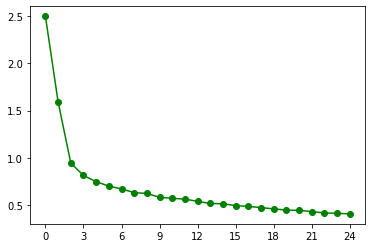

Final Cost: 0.40510815604594014
correct: 0.9573571428571429
Norm: 5.3414642961992325


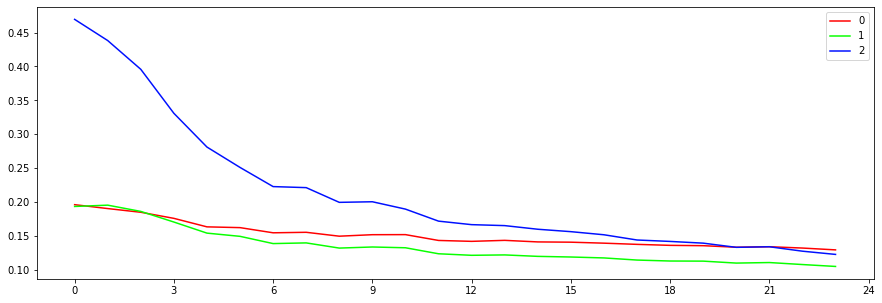

In [76]:
ShowCostFig(times,NN.cost)
NN.predict(trainX,trainy)
ShowNorm(NN.w[-1])
ShowdwFig(times,NN.dwNorm,NN.layerNum)

correct: 0.9491428571428572


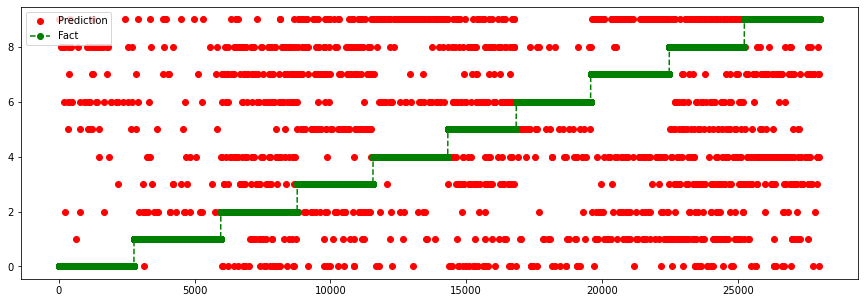

In [77]:
NN.predict(testX, testy)
#结果可视化
plt.figure(figsize=(15, 5))
plt.plot(NN.r, "ro", label = "Prediction")
plt.plot(np.array(testy).ravel(), "go--", label = "Fact")
plt.legend()
plt.show()

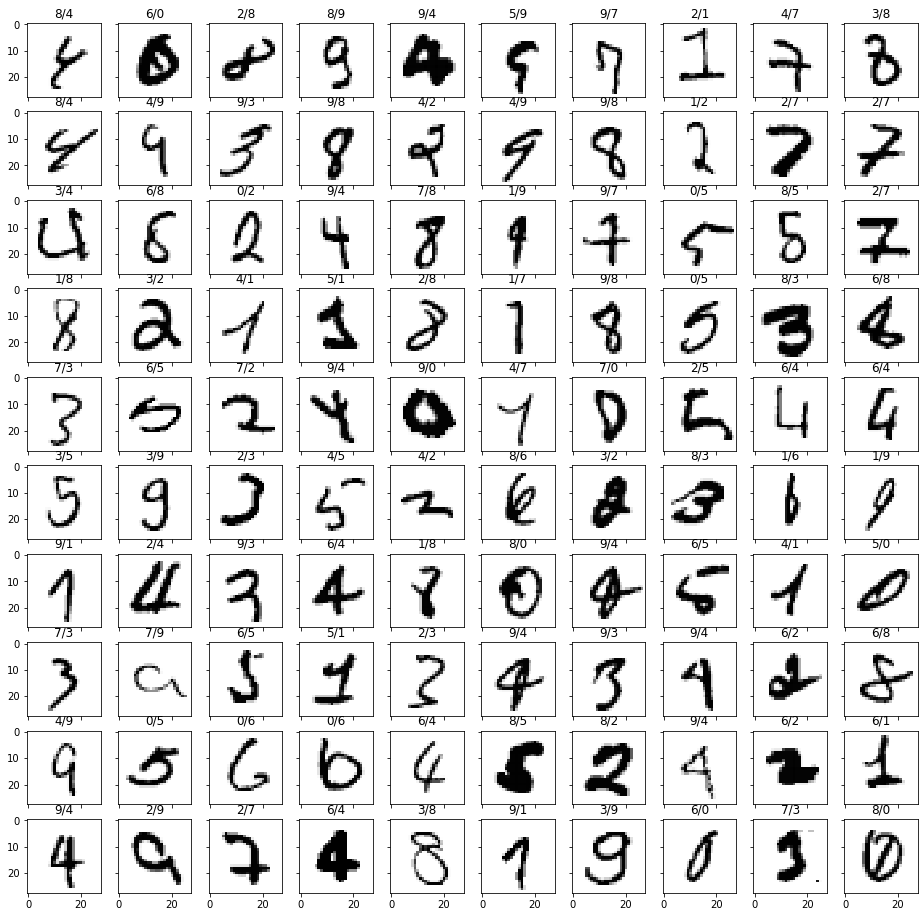

In [83]:
# 采样识别错误的样本
if len(NN.wrong) != 0:
    sampleIndex = np.random.choice([i for i in range(len(NN.wrong))],100,False)
    sample = []
    for i in sampleIndex:
        sample.append(NN.wrong[i])
    fig,ax = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True)
    fig.set_size_inches(16, 16)
    ax=ax.flatten()
    cnt = 0
    for i in sample:
        for j in range(len(dsTest.index)):
            if dsTest.index[j] == testX.index[i]:
                wrongIndex = j
                break
        sample = np.asarray(dsTest.iloc[wrongIndex,1:]).reshape(28,28)
        ax[cnt].imshow(sample, cmap='Greys', interpolation='nearest')
        ax[cnt].set_title(str(int(np.asarray(NN.r).ravel()[i]))+"/"+str(dsTest.iloc[wrongIndex,0]))
        cnt += 1